<a href="https://colab.research.google.com/github/KazukiHirata-sun/ai_project_dev_2022/blob/main/Appendix/image_classifier_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model training and preservation
Build and train a [CNN model](https://viblo.asia/p/deep-learning-tim-hieu-ve-mang-tich-chap-cnn-maGK73bOKj2) for [image identification](https://www.analyticsvidhya.com/blog/2020/02/learn-image-classification-cnn-convolutional-neural-networks-3-datasets/) at Google Colaboratory.  
In this case, we will use [cifar-10](https://www.cs.toronto.edu/~kriz/cifar.html) as training data.  
The trained model is saved and downloaded.

[Refarence](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

## Data Preprocessing
Load CIFAR-10 and configure DataLoader settings along with data expansion.  

In [ ]:
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

affine = transforms.RandomAffine([-15, 15], scale=(0.8, 1.2))  # Rotate and Resize
flip = transforms.RandomHorizontalFlip(p=0.5)  # right side flip
normalize = transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # Mean is 0, standard deviation is 1
to_tensor = transforms.ToTensor()

transform_train = transforms.Compose([affine, flip, to_tensor, normalize])
transform_test = transforms.Compose([to_tensor, normalize])
cifar10_train = CIFAR10("./data", train=True, download=True, transform=transform_train)
cifar10_test = CIFAR10("./data", train=False, download=True, transform=transform_test)

# DataLoader settings
batch_size = 64
train_loader = DataLoader(cifar10_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(cifar10_test, batch_size=len(cifar10_test), shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Model Building
Build a model of CNN as a class that inherits from the [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html) module.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # Convolutional layer: (number of input channels, number of filters, filter size)
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer: (area size, stride)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 256)  # Fully Connected layer
        self.dropout = nn.Dropout(p=0.5)  # Dropout
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

net = Net()
net.cuda()  # GPU
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=256, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)


## Learning
Train the model.  
Set the cross-entropy error as the [loss function](https://www.datarobot.com/blog/introduction-to-loss-functions/#:~:text=Further%20reading-,What's%20a%20loss%20function%3F,ll%20output%20a%20lower%20number.) and Adam as the [optimization algorithm](https://d2l.ai/chapter_optimization/index.html). 
Training takes time, so select GPU in Edit → Hardware Accelerator in Notebook Settings.

In [ ]:
from torch import optim

# Cross Entropy
loss_fnc = nn.CrossEntropyLoss()

# Optimization Algorithm
optimizer = optim.Adam(net.parameters())

record_loss_train = []
record_loss_test = []

# Leaning
x_test, t_test = iter(test_loader).next()
x_test, t_test = x_test.cuda(), t_test.cuda()
for i in range(60):  # 20 epoc
    net.train()  # Train
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):  # Mini Batch
        x, t = x.cuda(), t.cuda()  # GPU
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_train /= j+1
    record_loss_train.append(loss_train)

    net.eval()  # evalation 
    y_test = net(x_test)
    loss_test = loss_fnc(y_test, t_test).item()
    record_loss_test.append(loss_test)

    if i%1 == 0:
        print("Epoch:", i, "Loss_Train:", loss_train, "Loss_Test:", loss_test)

Epoch: 0 Loss_Train: 1.8178053952543938 Loss_Test: 1.513047695159912
Epoch: 1 Loss_Train: 1.5625889141236424 Loss_Test: 1.426042079925537
Epoch: 2 Loss_Train: 1.4822565387277042 Loss_Test: 1.4464085102081299
Epoch: 3 Loss_Train: 1.441580539774102 Loss_Test: 1.297171950340271
Epoch: 4 Loss_Train: 1.4031599371329597 Loss_Test: 1.3101367950439453
Epoch: 5 Loss_Train: 1.3783907308755323 Loss_Test: 1.2612998485565186
Epoch: 6 Loss_Train: 1.351784713356696 Loss_Test: 1.2241227626800537
Epoch: 7 Loss_Train: 1.3313880937788494 Loss_Test: 1.207461953163147
Epoch: 8 Loss_Train: 1.3218365366501577 Loss_Test: 1.188754916191101
Epoch: 9 Loss_Train: 1.3085939118929226 Loss_Test: 1.1783608198165894
Epoch: 10 Loss_Train: 1.294917230410954 Loss_Test: 1.1479718685150146
Epoch: 11 Loss_Train: 1.2882193065512821 Loss_Test: 1.1549370288848877
Epoch: 12 Loss_Train: 1.278530491968555 Loss_Test: 1.1513912677764893
Epoch: 13 Loss_Train: 1.2641443352565132 Loss_Test: 1.1330662965774536
Epoch: 14 Loss_Train: 1.2

## Error Trends
Displays graphs of error trends in training and test data.

[Refarence](https://matplotlib.org/) 

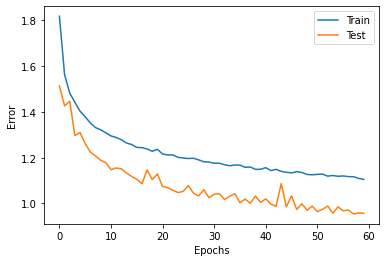

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()

## Accuracy
To understand the performance of the model, we measure the percentage of correct answers using test data.

In [ ]:
correct = 0
total = 0
net.eval()  # Evaluation
for i, (x, t) in enumerate(test_loader):
    x, t = x.cuda(), t.cuda()  # GPU
    y = net(x)
    correct += (y.argmax(1) == t).sum().item()
    total += len(x)
print("Accuracy:", str(correct/total*100) + "%")

Accuracy: 66.67%


## Save model
Save the parameters of the trained model.    
Each parameter of the model can be obtained by `state_dict()`, so save it.

In [ ]:
import torch

for key in net.state_dict():
    print(key, ": ", net.state_dict()[key].size())
print(net.state_dict()["conv1.weight"][0]) 

# Save Model
torch.save(net.state_dict(), "model_cnn.pth")  

conv1.weight :  torch.Size([6, 3, 5, 5])
conv1.bias :  torch.Size([6])
conv2.weight :  torch.Size([16, 6, 5, 5])
conv2.bias :  torch.Size([16])
fc1.weight :  torch.Size([256, 400])
fc1.bias :  torch.Size([256])
fc2.weight :  torch.Size([10, 256])
fc2.bias :  torch.Size([10])
tensor([[[-0.1136, -0.0908, -0.0499, -0.0933, -0.1454],
         [-0.0551,  0.0252, -0.0822,  0.0250, -0.0669],
         [-0.0651,  0.0495, -0.0833,  0.0535, -0.0105],
         [-0.2433,  0.2115,  0.0122,  0.0257,  0.1613],
         [-0.2925, -0.0237,  0.1146,  0.1092,  0.1164]],

        [[ 0.1126,  0.1740,  0.1844,  0.1054,  0.2450],
         [ 0.0551,  0.0716,  0.1097,  0.1131,  0.0729],
         [ 0.1398,  0.1800,  0.1102,  0.1274,  0.2823],
         [ 0.0565,  0.1218,  0.1232,  0.0533, -0.0290],
         [-0.1140,  0.0026,  0.1542,  0.0902, -0.0584]],

        [[-0.0688, -0.1278, -0.1021, -0.0097, -0.1660],
         [ 0.0231, -0.0810, -0.0695, -0.0888,  0.0222],
         [ 0.0044, -0.1138, -0.2644, -0.0748, -0